In [1]:
%load_ext autoreload
%autoreload 2

#### First try using their pipeline
That means feeding the model text input and then they feed it through the language model and get embeddings

In [2]:
from repe import repe_pipeline_registry
from transformers import pipeline
repe_pipeline_registry()

In [3]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer

model = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-70m",
  cache_dir="./pythia-70m/main",
)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m",
  cache_dir="./pythia-70m/main",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
numbers = pd.read_csv('../mixed_true_false_data/train/numbers.csv')

In [77]:
# need an even number of inputs!
# num_examples = len(numbers) - (numbers % 2)
num_examples = 50
inputs = numbers.iloc[:num_examples].statement.tolist()
labels = numbers.iloc[:num_examples].label.tolist()

In [78]:
# seems that if you are passing training labels then it's not able to create the example pairs itself
# so try giving everything already paired
true_inputs = numbers[numbers.label == 1].iloc[:num_examples].statement.tolist()
false_inputs = numbers[numbers.label == 0].iloc[:num_examples].statement.tolist()
paired_inputs = list(zip(true_inputs, false_inputs))
paired_labels = [[1, 0]] * len(paired_inputs)

In [79]:
tokenizer.pad_token = tokenizer.eos_token

In [80]:
finder = rep_reading_pipeline.get_directions(
    paired_inputs,
    batch_size=1,
    train_labels=paired_labels,
    padding=True,
)

In [81]:
results = rep_reading_pipeline(
    inputs,
    rep_reader=finder,
    batch_size=1,
)

In [82]:
labels_arr = np.array(labels)
results_arr = np.array(list(d[-1].item() for d in results))
true_scores = results_arr[labels_arr]
false_scores = results_arr[~labels_arr]

(array([26.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.]),
 array([30.26219177, 30.62154465, 30.98089752, 31.3402504 , 31.69960327,
        32.05895615, 32.41830902, 32.7776619 , 33.13701477, 33.49636765,
        33.85572052]),
 <BarContainer object of 10 artists>)

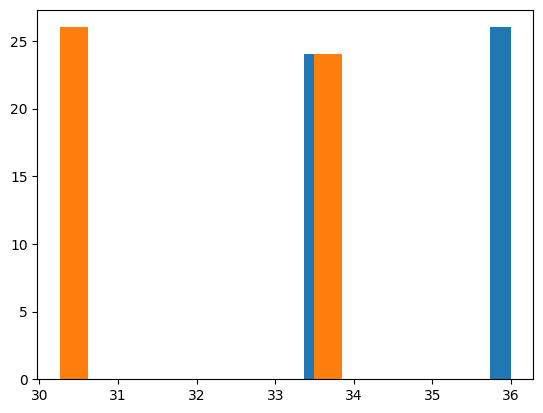

In [83]:
fig, ax = plt.subplots()
ax.hist(true_scores)
ax.hist(false_scores)

In [84]:
# wtf??? why are there only three possible scores
set(true_scores), set(false_scores)

({33.363075256347656, 35.99592590332031},
 {30.262191772460938, 33.85572052001953})

### Try with pre-calculated Llama embeddings

So need to use the underlying PCARepReader rather than the pipeline

In [19]:
from repe.rep_readers import PCARepReader
from ast import literal_eval

In [16]:
number_embs = pd.read_csv('../llama-true-false-results/train/embeddings_numbers7B_-5.csv')
number_embs

,Unnamed: 0.1,Unnamed: 0,original_idx,statement,label,n1,n2,diff,abs_diff,embeddings
0,692,784,1084,Seventy-seven is smaller than eighty-three.,1,77,83,-6,6,"[-2.427211046218872, 0.45658180117607117, 0.39..."
1,443,780,1080,Seventy-seven is larger than seventy-eight.,0,77,78,-1,1,"[-2.0737123489379883, 0.43445533514022827, 0.1..."
2,783,156,795,Seventy-one is smaller than fifty-four.,0,71,54,17,17,"[-2.027088165283203, 0.28480812907218933, 0.21..."
3,432,736,967,Seventy-four is larger than ninety-nine.,0,74,99,-25,25,"[-2.416747570037842, 0.6019255518913269, 0.099..."
4,200,800,1780,Ninety-five is larger than seventy-three.,1,95,73,22,22,"[-2.3882596492767334, 0.26912882924079895, 0.2..."
...,...,...,...,...,...,...,...,...,...,...
838,928,736,1705,Ninety-three is smaller than eighty-seven.,0,93,87,6,6,"[-2.4358463287353516, 0.3964245319366455, 0.30..."
839,12,48,443,Sixty-two is larger than fifty-four.,1,62,54,8,8,"[-1.9348537921905518, 0.33280178904533386, 0.2..."
840,706,840,1218,Eighty-one is smaller than eighty-five.,1,81,85,-4,4,"[-2.1126511096954346, 0.3045756220817566, 0.05..."
841,319,284,305,Fifty-seven is larger than ninety-seven.,0,57,97,-40,40,"[-2.381692886352539, 0.3664587438106537, 0.502..."


In [65]:
true_embs = np.array(number_embs[number_embs.label == 1].iloc[:num_examples].embeddings.apply(literal_eval).tolist())
false_embs = np.array(number_embs[number_embs.label == 0].iloc[:num_examples].embeddings.apply(literal_eval).tolist())
emb_diffs = np.array([t_emb - f_emb for t_emb, f_emb in zip(true_embs, false_embs)])
all_embs = np.concatenate([true_embs, false_embs], axis=0)
all_embs_labels = [1] * len(true_embs) + [0] * len(false_embs)

In [66]:
all_embs.shape

(100, 4096)

In [53]:
np.array(list(zip(true_embs, false_embs))).shape

(50, 2, 4096)

In [67]:
reader = PCARepReader(1)
# hidden_states needs to be indexed by layer
layer = -5
hidden_states = {layer: emb_diffs}
# receives model and tokenizer but doesn't use them?...
reader.directions = reader.get_rep_directions(None, None, hidden_states, hidden_layers=[layer])
# they do this in their pipeline for some reason
directions[layer] = directions[layer].astype(np.float32)

# seems that the hidden layers need to be a flat list while the labels need to be in pairs but in the same order? maybe??...
alternating_hs = np.array(list(zip(true_embs, false_embs))).reshape(num_examples*2, -1)
paired_labels = [[1, 0]] * (len(alternating_hs) // 2)
reader.direction_signs = reader.get_signs({layer: alternating_hs}, paired_labels, [layer])

In [72]:
scores = reader.transform({layer: all_embs}, [layer], component_index=0)
scores = scores[layer]
true_scores = scores[:len(true_embs)]
false_scores = scores[len(true_embs):]

(array([3., 4., 5., 6., 3., 9., 5., 6., 2., 7.]),
 array([2194.14847237, 2201.48465268, 2208.82083299, 2216.1570133 ,
        2223.49319361, 2230.82937391, 2238.16555422, 2245.50173453,
        2252.83791484, 2260.17409515, 2267.51027546]),
 <BarContainer object of 10 artists>)

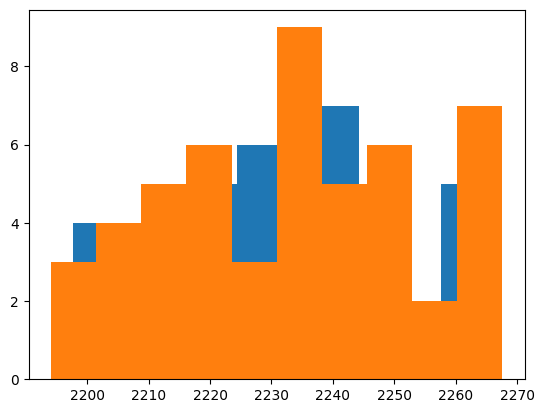

In [73]:
fig, ax = plt.subplots()
ax.hist(true_scores)
ax.hist(false_scores)

In [74]:
true_scores.mean(), false_scores.mean()

(2231.9506319964353, 2232.789570210858)